In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_auc_score
import datetime
import random
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import json
from collections import Counter
%matplotlib inline

# Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

**Conclusions:**

The data follow a weekly as well as a daily pattern. With more rides over the weekend on overage compared to weekdays. The time distribution of rides for weekdays peaks in the morning, lunchtime and evening after 6 pm. For weekends the majority of rides are during the night time.

The plots are shown below:

In [2]:
# Load json file into dataframe
logins = pd.read_json('logins.json')

# Set index to login_time
logins = logins.set_index('login_time')

# Set login counts to 1 for each time stamp
logins['login_counts'] = 1

# Aggregate login counts over 15 min intervals.
logins_every_15min = logins.resample('15T').count()

**Inspect resulting dataframe.**

In [3]:
logins_every_15min.head()

,login_counts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [4]:
logins_every_15min.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
login_counts    9788 non-null int64
dtypes: int64(1)
memory usage: 152.9 KB


**Plot time series history over the entire recorder range.**

In [5]:
def series_plotter(df, time_label):
    '''This function plots time series data from input df.'''
    
    fig, ax = plt.subplots(figsize=(10, 7))

    _ = plt.plot(df.index, df.login_counts)
    _ = plt.gcf().autofmt_xdate()
    _ = ax.set(xlabel='time', 
               ylabel='login counts', 
               title = 'Login counts summed over 15 minutes as a function of time: ' 
               + time_label)

    return plt.show()

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


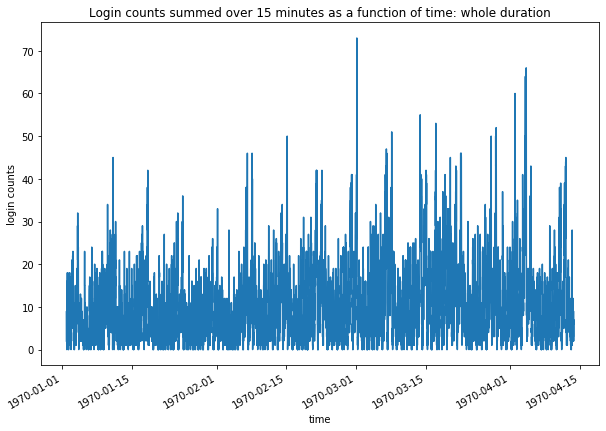

In [6]:
series_plotter(logins_every_15min, 'whole duration')

**Plot time series for a weekday**

In [7]:
logins_every_15min_weekday = logins_every_15min.loc['1970-02-23']

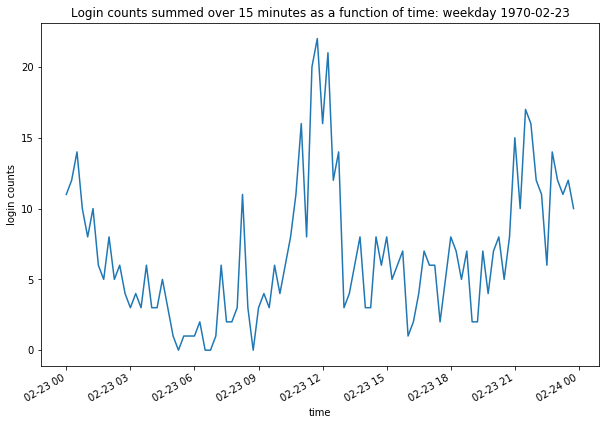

In [8]:
series_plotter(logins_every_15min_weekday, 'weekday 1970-02-23')

**Plot time series for a weekend.**

In [9]:
logins_every_15min_weekend = logins_every_15min.loc['1970-02-21']

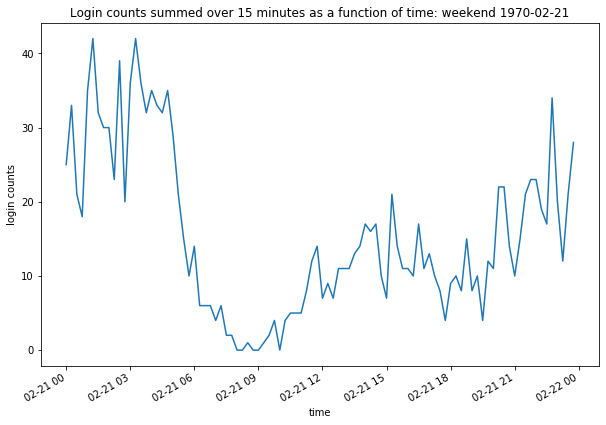

In [10]:
series_plotter(logins_every_15min_weekend, 'weekend 1970-02-21')

# Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment

b. what statistical test(s) you will conduct to verify the significance of the observation

c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

# Solution:

**Metric:**

The key measure of success could be an increase in revenue as a result of the introduction of the toll reimbursement. The actual metric could be (based on a given number of drivers participating in the experiment, which should be more than 30): 

(average income with the new approach - total costs on reimbursement) - (average income before the new approach)

**Experiment:**

a. 

We can choose and monitor 1000 (can be more depending on available resoures) drivers who don't get toll reimbursements and 1000 drivers who do. We should monitor them over a weekly cycle, to take into account all the changes in the number and cost of rides. This weekly cycle should not coincide with public holidays and should not be close or during major holiday seasons, like Christmas time or Easter time.

b. 

- After the experiment is finished, we can combine both datasets and perform a hypothesis test with a null hypothesis being the assumption that there is no difference in revenue before and after introducing the toll reimbursement:

(average revenue with reimbursement - total costs on reimbursement) - (average revenue without reimbursement) = 0

- We can then perform virtual experiments by sampling with replacement from a combined dataset and obtaining a distribution of our test statistic: the difference of means. 

- We can then calculate a p-value and choose a threshold, for example, p=0.05. If the probability of obtaining a test statistic, at least as extreme as in the experiment, is smaller than 0.05, we can conclude that the results are statistically significant. 

c.

- If we conclude that the results are statistically significant, we can go ahead and recommend a two-way toll reimbursement strategy. However, we might need to adjust our results depending on the annual seasonality, for example, if the week when we did the experiment coincided with major national holidays or summer time holidays. 

# Part 3 ‐ Predictive modeling.

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

Data description

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’
    
● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
    
● avg_dist: the average distance in miles per trip taken in the first 30 days after signup
    
● avg_rating_by_driver: the rider’s average rating over all of their trips
    
● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
    
● surge_pct: the percent of trips taken with surge multiplier > 1
    
● avg_surge: The average surge multiplier over all of this user’s trips
    
● trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

# Predictive model and conclusions.

**Cleaning and EDA:**

- Performed replacement of missing values with a median value for numeric columns and a most frequent value for categorical columns (based on the training data). 

- Performed visual assessment of the distributions of selected variables, all assessed distributions were highly skewed.

- 24.4% of customers were retained.

**Machine learning model.**

- A logistic regression model was chosen as a benchmark classifier. 

- A complete workflow for the model assessment was performed below in the code, including hyperparameter tuning, K-fold cross-validation, plotting of a learning curve, a ROC curve, a precision-recall curve, and printing out a classification report.

- The results of the model performance on the test data are as follows:

| **Logistic reg** |precision | recall  | f1-score |
|------------------|----------|---------|----------|
|not retained      |   0.84   |  0.81   |  0.82    |
|   retained       |   0.46   |  0.51   |  0.49    |
|                  |          |         |          |
|   accuracy       |          |         |  0.73    |
|   AUC score      |          |         |  0.74    |

- The key metric of the model performance was chosen to be an AUC score as we are dealing with an imbalanced dataset.

- It is important to mention that there is a large number of false positives, which brings down the values of precision and recall for the positive class: retained customers.

- Using statsmodels the most important features contributing to the classification were assessed. 

The most important features are with |coef| > 0.2 an p-values < 0.05:

1. avg_rating_by_driver: the rider’s average rating over all of their trips

2. surge_pct: the percent of trips taken with surge multiplier > 1

3. avg_surge: the average surge multiplier over all of this user’s trips

**Recommendations based on insights:**

We concluded that the percent of trips taken with surge multiplier > 1 and the average surge multiplier are among the top factors in customer retention. The customers who use ride-sharing during busy times could have a better chance of being retained long term if offered better rates compared to the market average.

In [11]:
openfile=open('ultimate_data_challenge.json')
jsondata=json.load(openfile)
retention=pd.DataFrame(jsondata)

openfile.close()

In [12]:
retention.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


# Preprocessing the original dataset to get a target variable, whether a person was active or not in the last 30 days.

**Perfom the following steps.**

**1. Convert signup_date and last_trip_date to datetime object.** 

**2. Add 6 months to signup_date to get 6months_on_system_date.** 

**3. Subtract last_trip_date from 6months_on_system_date to get number of days since last trip date.**

**4. Create a categorical variable, 0 if not active for more than 30 days since last trip date, and 1 if active within the last 30 days since last trip date.** 

In [13]:
# step 1 as outlined above
retention['signup_date']= pd.to_datetime(retention['signup_date'])
retention['last_trip_date']= pd.to_datetime(retention['last_trip_date'])

# step 2 as outlined above
retention['6months_on_system_date'] = \
    retention.signup_date + pd.offsets.MonthOffset(6)

# step 3 as outlined above
retention['days_recent_activity'] = \
    pd.Series(delta.days for delta in (retention['6months_on_system_date'] - retention['last_trip_date']))

# step 4 as outlined above
bins = [0,30,360]
labels=[1,0]
retention['active'] = pd.cut(retention['days_recent_activity'], 
                             bins=bins, 
                             labels=labels, 
                             include_lowest=True)

**Drop no more relevant datetime columns.**

In [14]:
retention = retention.drop(['signup_date', 
                            'last_trip_date',
                            '6months_on_system_date',
                            'days_recent_activity'], 
                           axis = 1)

# Train-test split.

In [15]:
X_columns = retention.drop(['active'], axis = 1).columns
X = retention.drop(['active'], axis = 1).values
y = retention[['active']].values.ravel()

**Calculate the percentage of customers retained.**

In [16]:
print('Percentage of retained customers: ', 
      (Counter(y)[1]/(Counter(y)[0] + Counter(y)[1]))*100)

Percentage of retained customers:  24.396


In [17]:
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, stratify = y, 
                         test_size=0.3, 
                         random_state=1)

In [18]:
X_train = pd.DataFrame(X_train, columns = X_columns)
X_test = pd.DataFrame(X_test, columns = X_columns)

# Converting back numpy arrays to dataframes with appropriate column data types. 

In [19]:
X_train['trips_in_first_30_days'] = \
    X_train['trips_in_first_30_days'].astype(int)
X_test['trips_in_first_30_days'] = \
    X_test['trips_in_first_30_days'].astype(int)

In [20]:
X_train[['avg_rating_of_driver', 
         'avg_surge', 
         'surge_pct', 
         'weekday_pct', 
         'avg_dist', 
         'avg_rating_by_driver']] = \
    X_train[['avg_rating_of_driver', 
             'avg_surge', 
             'surge_pct', 
             'weekday_pct', 
             'avg_dist', 
             'avg_rating_by_driver']].astype(float)
X_test[['avg_rating_of_driver', 
         'avg_surge', 
         'surge_pct', 
         'weekday_pct', 
         'avg_dist', 
         'avg_rating_by_driver']] = \
    X_test[['avg_rating_of_driver', 
             'avg_surge', 
             'surge_pct', 
             'weekday_pct', 
             'avg_dist', 
             'avg_rating_by_driver']].astype(float)

In [21]:
X_train['ultimate_black_user'] = \
    X_train['ultimate_black_user'].astype(bool)
X_test['ultimate_black_user'] = \
    X_test['ultimate_black_user'].astype(bool)

# Vizualizing avg_rating_of_driver, avg_rating_by_driver, weekday_pct features (for example) to get information about their distributions.

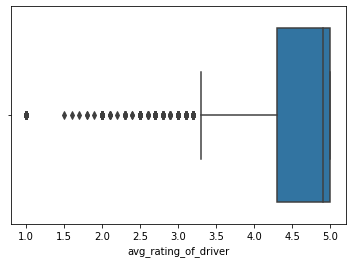

In [22]:
_ = sns.boxplot(X_train['avg_rating_of_driver'])  
plt.show()

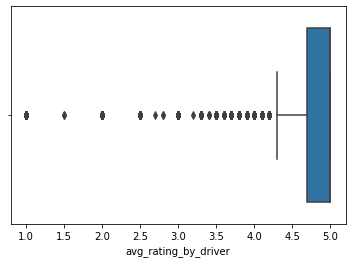

In [23]:
_ = sns.boxplot(X_train['avg_rating_by_driver'])  
plt.show()

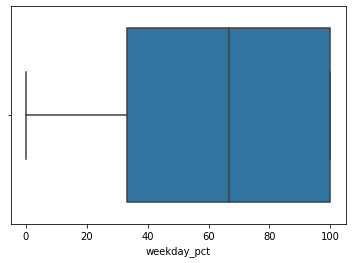

In [24]:
_ = sns.boxplot(X_train['weekday_pct'])  
plt.show()

# Replacing outliers, imputing missing numerical and categorical values.

In [25]:
def outlier_replace(data,train,column):
    quartile_1, quartile_3 = np.percentile(train[column], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (float(iqr) * 1.5)
    upper_bound = quartile_3 + (float(iqr) * 1.5)
    data.loc[(data[column]<lower_bound) | (data[column] > upper_bound),[column]] = \
        train[column].median()
    return data[column]

In [26]:
def imputation_missing_numerical(data,train,column):
    data[column].fillna(train[column].median(),
                       inplace = True)
    return data[column]

In [27]:
def imputation_missing_categorical(data,train,column):
    data[column].fillna(train[column].mode().iloc[0],
                       inplace = True)
    return data[column]   

In [28]:
# getting list of numeric column names
float_columns = X_train.select_dtypes(include=['float64']).columns
int_columns = X_train.select_dtypes(include=['int64']).columns
numeric_columns = float_columns.union(int_columns)

# getting list of categorical and boolean column names
categorical_columns = \
    X_train.select_dtypes(include=['object', 'bool']).columns

In [29]:
for numeric in numeric_columns:
    
    X_train[numeric] = imputation_missing_numerical(X_train,
                                                    X_train,
                                                    numeric)
    X_train[numeric] = outlier_replace(X_train,
                                       X_train,
                                       numeric)
    
    X_test[numeric] = imputation_missing_numerical(X_test,
                                                   X_train,
                                                   numeric)   
    X_test[numeric] = outlier_replace(X_test,
                                      X_train,
                                      numeric)
    
for categorical in categorical_columns:
    X_train[categorical] = imputation_missing_categorical(X_train,
                                                          X_train,
                                                          categorical)
    X_test[categorical] = imputation_missing_categorical(X_test,
                                                         X_train,
                                                         categorical)

# Visualizing after imputing missing values and outliers.

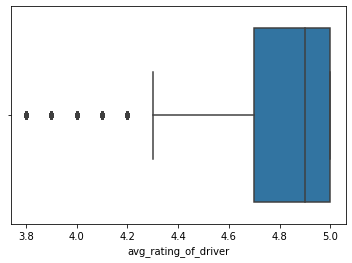

In [30]:
_ = sns.boxplot(X_train['avg_rating_of_driver'])  
plt.show()

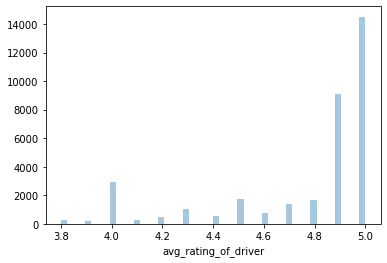

In [31]:
_ = sns.distplot(X_train['avg_rating_of_driver'], kde = False)  
plt.show()

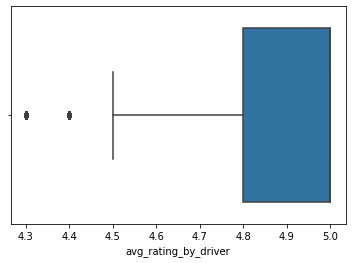

In [32]:
_ = sns.boxplot(X_train['avg_rating_by_driver'])  
plt.show()

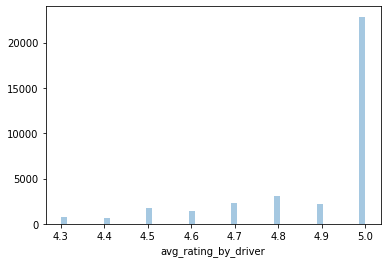

In [33]:
_ = sns.distplot(X_train['avg_rating_by_driver'], kde = False)  
plt.show()

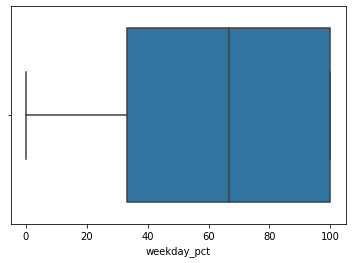

In [34]:
_ = sns.boxplot(X_train['weekday_pct'])  
plt.show()

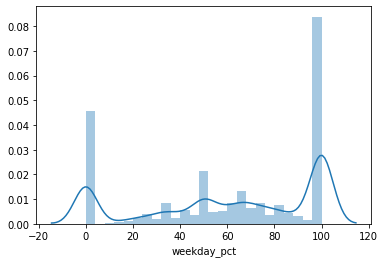

In [35]:
_ = sns.distplot(X_train['weekday_pct'])  
plt.show()

# Replace catergorical columns with the columns containing dummy variables

In [36]:
def dummies(data,col):
    y = pd.get_dummies(data[col],prefix=col)
    data.drop([col],axis=1,inplace=True)
    return y

In [37]:
X_train_dummies  = \
    pd.concat([dummies(X_train,col) for col in categorical_columns], 
              axis=1)
X_test_dummies  = \
    pd.concat([dummies(X_test,col) for col in categorical_columns], 
              axis=1) 

# Standardize the numeric columns in the dataset, fit and transform on train, then  transform test.

In [38]:
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

# Combine all preprocessed columns together.

In [39]:
X_train = pd.concat([X_train[numeric_columns],X_train_dummies],
                    axis=1)
X_test = pd.concat([X_test[numeric_columns],X_test_dummies],
                   axis=1)

# Define necessary functions to evaluate ML model.

In [40]:
scorer = make_scorer(roc_auc_score, 
                     greater_is_better=True, 
                     needs_proba = True)

In [41]:
def learning_curve_output(X_train, y_train, clf):
    ''' This function outputs the model performance 
    for different sizes of training dataset: learning curve.'''
    
    train_sizes, train_scores, test_scores =\
                    learning_curve(estimator=clf, 
                    X=X_train, 
                    y=y_train,
                    train_sizes=np.linspace(0.1, 1.0, 5),
                    cv=5,
                    scoring = scorer,
                    n_jobs=-1,
                    shuffle=True)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    return train_sizes, train_mean, train_std, test_mean, test_std

In [42]:
def learning_curve_plt(train_sizes, train_mean, train_std, test_mean, test_std, clf_name):
    '''This function plots a learning curve for different classifiers.'''
    
    _ = plt.figure(figsize=(7,5))
    _ = plt.plot(train_sizes, train_mean, 
                 color='blue', marker='o', 
                 markersize=5, label='training AUC')

    _ = plt.fill_between(train_sizes, 
                         train_mean + train_std,
                         train_mean - train_std, 
                         alpha=0.15, color='blue')

    _ = plt.plot(train_sizes, test_mean, 
                 color='green', linestyle='--', 
                 marker='s', markersize=5, 
                 label='validation AUC')

    _ = plt.fill_between(train_sizes, 
                         test_mean + test_std,
                         test_mean - test_std, 
                         alpha=0.15, color='green')

    _ = plt.title('Learning curve for ' + str(clf_name))
    _ = plt.xlabel('Number of training samples', fontsize=14)
    _ = plt.ylabel('AUC score', fontsize=14)
    _ = plt.legend(loc='lower right', fontsize=14)
    _ = plt.ylim([min(test_mean) - 0.025, max(train_mean) + 0.025])
    _ = plt.tight_layout()
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
    
    return plt.show()

In [43]:
def validation_curve_output(X_train, y_train, clf, param_range, param_name):
    '''This function outputs the model performance as a funtion of a certain 
    model parameter with the other parameters fixed: validation curve.'''
    
    train_scores, test_scores = validation_curve(
                    estimator=clf, 
                    X=X_train, 
                    y=y_train, 
                    param_name=param_name, 
                    param_range=param_range,
                    cv=5,
                    scoring = scorer,
                    n_jobs = -1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    return train_mean, train_std, test_mean, test_std

In [44]:
def validation_curve_plt(train_mean, train_std, test_mean, test_std, param_range, param_name, clf_name):
    '''This function plots the validation curve for different models'''
    
    _ = plt.figure(figsize=(7,5))
    _ = plt.plot(param_range, train_mean, 
                 color='blue', marker='o', 
                 markersize=5, label='training AUC')

    _ = plt.fill_between(param_range, train_mean + train_std,
                         train_mean - train_std, alpha=0.15,
                         color='blue')

    _ = plt.plot(param_range, test_mean, 
                 color='green', linestyle='--', 
                 marker='s', markersize=5, 
                 label='validation AUC')

    _ = plt.fill_between(param_range, 
                         test_mean + test_std,
                         test_mean - test_std, 
                         alpha=0.15, color='green')

    _ = plt.xscale('log')
    _ = plt.legend(loc='lower right', fontsize = 14)
    _ = plt.xlabel('Parameter ' + str(param_name), fontsize = 14)
    _ = plt.ylabel('AUC score', fontsize = 14)
    _ = plt.title('Validation curve for ' + str(clf_name) + ':' + 
                  str(param_name), fontsize = 14)
    _ = plt.ylim([min(test_mean) - 0.025, max(train_mean) + 0.025])
    _ = plt.tight_layout()
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
    
    return plt.show()

In [45]:
def ROC_plt(y_pred_train, y_pred_test, classifier):
    '''This function plots ROC curve for a given model.'''

    fpr_train, tpr_train, thresholds_train = roc_curve(y_true=y_train, 
                                                       y_score=y_pred_train)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_true=y_test, 
                                                    y_score=y_pred_test)

    roc_auc_train = auc(x=fpr_train, y=tpr_train)
    roc_auc_test = auc(x=fpr_test, y=tpr_test)

    _ = plt.figure(figsize=(7,5))
    _ = plt.plot(fpr_train, tpr_train, color='black', linestyle='-', 
                 label='%s (auc = %0.3f)' % (classifier + ' train', 
                                             roc_auc_train))
    _ = plt.plot(fpr_test, tpr_test, color='red', linestyle='-', 
                 label='%s (auc = %0.3f)' % (classifier + ' test', 
                                             roc_auc_test))
    _ = plt.plot([0, 1], [0, 1], linestyle='--', color='gray', 
                 linewidth=2)

    _ = plt.legend(loc='lower right', fontsize = 14)
    _ = plt.xlim([0., 1.])
    _ = plt.ylim([0., 1.])
    _ = plt.xlabel('False Positive Rate', fontsize = 14)
    _ = plt.ylabel('True Positive Rate', fontsize = 14)
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
    _ = plt.tight_layout()
    _ = plt.title('ROC curve', fontsize = 14)
    
    return plt.show()

In [46]:
def precision_recall_curve_plt(y_pred_train, y_pred_test, classifier):
    '''This function plots precision-recall curve for a given model.'''

    average_precision = average_precision_score(y_true = y_test, 
                                                y_score = y_pred_test)

    precision_train, recall_train, thresholds_train = \
        precision_recall_curve(y_true=y_train, 
                               probas_pred=y_pred_train)
    precision_test, recall_test, thresholds_test = \
        precision_recall_curve(y_true=y_test, 
                               probas_pred=y_pred_test)

    _ = plt.figure(figsize=(7,5))
    _ = plt.plot(recall_train, precision_train, color='black', 
                 linestyle='-', 
                 label='%s' % (classifier + ' train'))
    _ = plt.plot(recall_test, precision_test, color='red', 
                 linestyle='-', 
                 label='%s' % (classifier + ' test'))
    _ = plt.legend(loc='lower right', fontsize = 14)
    _ = plt.xlim([0., 1.])
    _ = plt.ylim([0., 1.])
    _ = plt.xlabel('Recall', fontsize = 14)
    _ = plt.ylabel('Precision', fontsize = 14)
    _ = plt.tight_layout()
    _ = plt.title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision), 
                  fontsize = 14)
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
    
    return plt.show()

# Logistic regression.

In [47]:
clf = LogisticRegression(solver = 'lbfgs', 
                         penalty = 'l2', 
                         n_jobs = -1, 
                         max_iter = 500, 
                         class_weight = 'balanced')

# Fit the model on the trainng data.
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print('Training accuracy (default logistic regression):', 
      accuracy_score(y_true = y_train, 
                     y_pred = y_pred_train))
print('Test accuracy (default logistic regression):', 
      accuracy_score(y_true = y_test, 
                     y_pred = y_pred_test))

print('AUC score for the training data (default logistic regression):', 
      roc_auc_score(y_true = y_train, 
                    y_score = clf.predict_proba(X_train)[:,1]))
print('AUC score for the test data (default logistic regression):', 
      roc_auc_score(y_true = y_test, 
                    y_score = clf.predict_proba(X_test)[:,1]))

Training accuracy (default logistic regression): 0.7205142857142857
Test accuracy (default logistic regression): 0.7344
AUC score for the training data (default logistic regression): 0.7759381736030753
AUC score for the test data (default logistic regression): 0.736857316357951


# Validation curves (logistic regression)

In [48]:
C_lr = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

train_mean_lr_C, train_std_lr_C, test_mean_lr_C, test_std_lr_C = \
    validation_curve_output(X_train.values, 
                            y_train, 
                            clf, 
                            C_lr, 
                            'C')

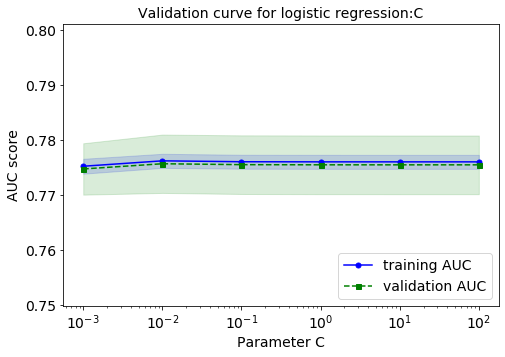

In [49]:
validation_curve_plt(train_mean_lr_C, 
                     train_std_lr_C, 
                     test_mean_lr_C, 
                     test_std_lr_C, 
                     C_lr, 
                     'C', 
                     'logistic regression')

# Hyperparameter tuning using grid search (logistic regression)

In [50]:
C_range = [0.01, 0.1, 1, 10, 100]
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

param_grid = [{'C': C_range, 'solver': solvers}]

gs = GridSearchCV(estimator=clf, 
                  param_grid=param_grid, 
                  scoring=scorer, 
                  cv=5,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print('Best AUC score on training data: ' + str(gs.best_score_))
print('Best parameters: ' + str(gs.best_params_))

Best AUC score on training data: 0.7756745204191791
Best parameters: {'C': 0.01, 'solver': 'liblinear'}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [51]:
best_clf = gs.best_estimator_
best_clf.fit(X_train, y_train)
print('AUC score on test data: %.3f' 
      %roc_auc_score(y_true = y_test, 
                     y_score = best_clf.predict_proba(X_test)[:,1]))

AUC score on test data: 0.737


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


# Stratified K-fold cross-validation (logistic regression).

In [52]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for k, (train_fold, test_fold) in enumerate(kfold.split(X_train.values, y_train)):
    best_clf.fit(X_train.values[train_fold], y_train[train_fold])
    score = roc_auc_score(y_true = y_train[test_fold], 
                          y_score = best_clf.predict_proba(X_train.values[test_fold])[:,1])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Train AUC score: %.3f' 
          %(k+1, np.bincount(y_train[train_fold]), score))
    
print('\n CV AUC score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Fold: 1, Class dist.: [21168  6831], Train AUC score: 0.784


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Fold: 2, Class dist.: [21169  6831], Train AUC score: 0.778


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Fold: 3, Class dist.: [21169  6831], Train AUC score: 0.771
Fold: 4, Class dist.: [21169  6831], Train AUC score: 0.776


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Fold: 5, Class dist.: [21169  6832], Train AUC score: 0.771

 CV AUC score: 0.776 +/- 0.005


# Learning curve (logistic regression)

In [53]:
train_sizes_lr_lc, train_mean_lr_lc, train_std_lr_lc, test_mean_lr_lc, test_std_lr_lc = \
    learning_curve_output(X_train.values, 
                          y_train, 
                          best_clf)

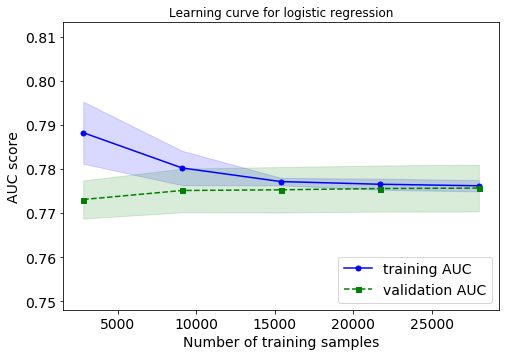

In [54]:
learning_curve_plt(train_sizes_lr_lc, 
                   train_mean_lr_lc, 
                   train_std_lr_lc, 
                   test_mean_lr_lc, 
                   test_std_lr_lc,
                  'logistic regression')

# Confusion matrix (logistic regression)

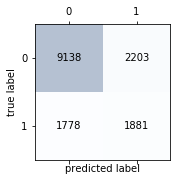

In [55]:
y_pred = best_clf.predict(X_test)
confmat = confusion_matrix(y_true=y_test, 
                           y_pred=y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, 
           alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], 
                va='center', 
                ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.show()

# Classification report for test data.

In [56]:
print('AUC score for the test data:', 
      roc_auc_score(y_true = y_test, 
                    y_score = best_clf.predict_proba(X_test)[:,1]))

AUC score for the test data: 0.7373600308014713


In [57]:
from sklearn.metrics import classification_report
print(classification_report(y_test, 
                            y_pred,
                            target_names = ['not retained', 
                                            'retained']))

              precision    recall  f1-score   support

not retained       0.84      0.81      0.82     11341
    retained       0.46      0.51      0.49      3659

    accuracy                           0.73     15000
   macro avg       0.65      0.66      0.65     15000
weighted avg       0.75      0.73      0.74     15000



# ROC and Precision - Recall curves (logistic regression).

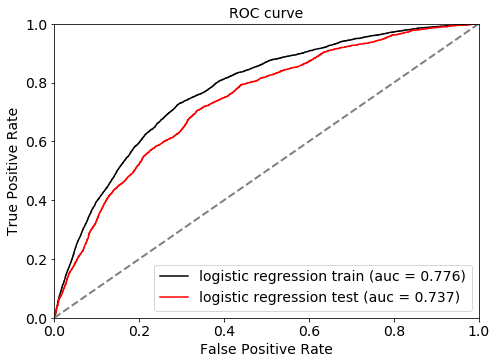

In [58]:
# assuming the label of the positive class is 1
y_pred_lr_train = best_clf.predict_proba(X_train)[:, 1]
y_pred_lr_test = best_clf.predict_proba(X_test)[:, 1]

ROC_plt(y_pred_lr_train, 
        y_pred_lr_test, 
        'logistic regression')

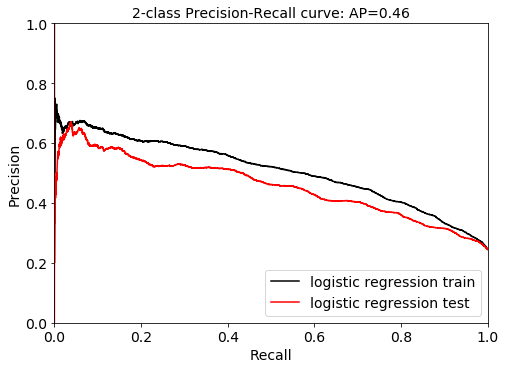

In [59]:
precision_recall_curve_plt(y_pred_lr_train, 
                           y_pred_lr_test, 
                           'logistic regression')

# Feature importance using logistic regression and statsmodels.

In [60]:
import statsmodels.api as sm

# define the model
logit = sm.Logit(y_train, X_train)

# fit the model
result = logit.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.466831
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                35000
Model:                          Logit   Df Residuals:                    34988
Method:                           MLE   Df Model:                           11
Date:                Wed, 11 Mar 2020   Pseudo R-squ.:                  0.1598
Time:                        09:12:14   Log-Likelihood:                -16339.
converged:                       True   LL-Null:                       -19447.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
avg_dist                     -0.0396      0.014     -2.742      0.006      -0.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


**The most important features are with |coef| > 0.2 an p-values < 0.05:**

**1. avg_rating_by_driver**

**2. surge_pct**

**3. avg_surge**